In [1]:
from line_solver import *
import numpy as np
GlobalConstants.set_verbose(VerboseLevel.STD)

[[1.]
 [2.]
 [2.]]
INFO: Added 20 refined points between t=0.000000 and t=0.002001
INFO: Added 20 refined points between t=0.000000 and t=0.002001
INFO: Added 20 refined points between t=0.000000 and t=0.002001
AvgRespTfromCDF[0] =
[[1.00393391]
 [2.01197944]
 [2.01197944]]
[[1.        ]
 [4.99999466]
 [2.00000531]]
INFO: Added 20 refined points between t=0.000000 and t=0.002001
INFO: Added 20 refined points between t=3.055716 and t=3.064954
INFO: Added 20 refined points between t=0.000000 and t=0.002001
AvgRespTfromCDF[1] =
[[1.00393605]
 [5.05636959]
 [2.01198791]]
[[ 1.        ]
 [12.99998945]
 [ 2.00001044]]
INFO: Added 20 refined points between t=0.000000 and t=0.002001
INFO: Added 20 refined points between t=4.432815 and t=4.451248
INFO: Added 20 refined points between t=0.000000 and t=0.002001
AvgRespTfromCDF[2] =
[[ 1.00393605]
 [13.11042617]
 [ 2.0119931 ]]


/tmp/ipykernel_19332/1743559548.py:96: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 200])


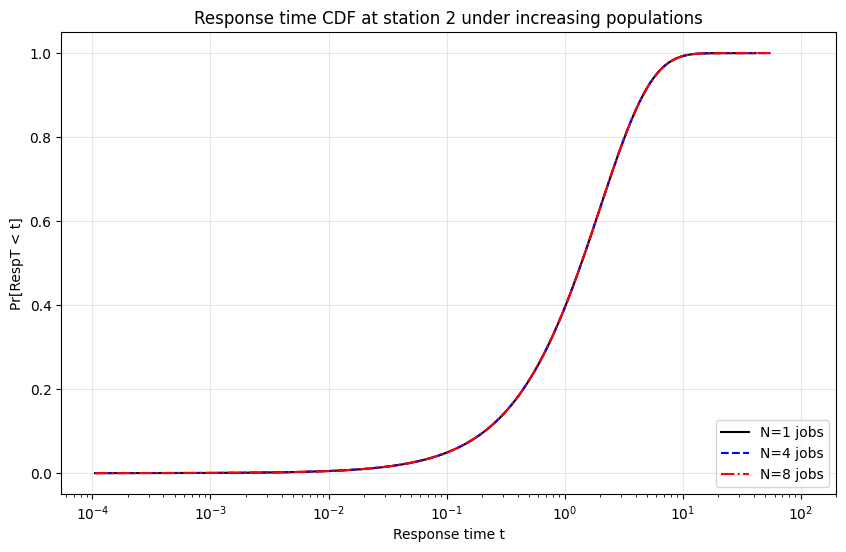

\nComparison across populations:


In [2]:
# CDF Response Time Analysis Example 5
# Closed network with varying job populations - CDF comparison

import matplotlib.pyplot as plt

# Initialize figure and data structures
plt.figure(figsize=(10, 6))
label = []
nJobs = [1, 4, 8]
plotColors = ['k', 'b--', 'r-.']

# Storage for results across different population sizes
AvgRespT = {}
AvgRespTfromCDF = {}
PowerMoment2_R = {}
Variance_R = {}
SqCoeffOfVariationRespTfromCDF = {}

for ni, N in enumerate(nJobs):
    # Create model for this population size
    model = Network('model')
    
    # Create closed queueing network
    node = [None] * 3  # using 0-based indexing
    node[0] = Delay(model, 'Delay')
    node[1] = Queue(model, 'Queue1', SchedStrategy.PS)
    node[2] = Queue(model, 'Queue2', SchedStrategy.PS)
    
    # Single closed class with N jobs
    jobclass = [None] * 1  # using 0-based indexing
    jobclass[0] = ClosedClass(model, 'Class1', N, node[0], 0)
    
    # Class doesn't complete (stays in system)
    jobclass[0].completes = False
    
    # Service processes - all exponential
    node[0].set_service(jobclass[0], Exp(1/1))  # rate = 1
    node[1].set_service(jobclass[0], Exp(1/2))  # rate = 0.5
    node[2].set_service(jobclass[0], Exp(1/2))  # rate = 0.5
    
    # Circular routing through all 3 stations
    P = model.init_routing_matrix()
    P.set(jobclass[0], jobclass[0], node[0], node[1], 1.0)
    P.set(jobclass[0], jobclass[0], node[1], node[2], 1.0)
    P.set(jobclass[0], jobclass[0], node[2], node[0], 1.0)
    model.link(P)
    
    # NOTE: JAR test shows JMT getCdfRespT is not working for this model configuration
    # So we only use Fluid solver like the working JAR test
    
    # Solve with Fluid solver - aligned with JAR test scenario
    options = FLD.default_options()
    options.iter_max = 100  # Aligned with JAR test: iter_max=100
    solver = FLD(model, options)
    
    AvgRespT[ni] = solver.avg_respt()
    FC = solver.cdf_respt()
    
    # Calculate statistics from CDF
    AvgRespTfromCDF[ni] = np.zeros((model.get_number_of_stations(), model.get_number_of_classes()))
    PowerMoment2_R[ni] = np.zeros((model.get_number_of_stations(), model.get_number_of_classes()))
    Variance_R[ni] = np.zeros((model.get_number_of_stations(), model.get_number_of_classes()))
    SqCoeffOfVariationRespTfromCDF[ni] = np.zeros((model.get_number_of_stations(), model.get_number_of_classes()))
    
    for c in range(model.get_number_of_classes()):
        for i in range(model.get_number_of_stations()):
            if FC[i][c] is not None and len(FC[i][c]) > 1:
                # Calculate mean from CDF
                diffs = np.diff(FC[i][c][:, 0])
                values = FC[i][c][1:, 1]
                AvgRespTfromCDF[ni][i, c] = np.sum(diffs * values)
                
                # Calculate second moment and variance
                PowerMoment2_R[ni][i, c] = np.sum(diffs * (values ** 2))
                Variance_R[ni][i, c] = PowerMoment2_R[ni][i, c] - AvgRespTfromCDF[ni][i, c] ** 2
                SqCoeffOfVariationRespTfromCDF[ni][i, c] = Variance_R[ni][i, c] / (AvgRespTfromCDF[ni][i, c] ** 2)
    
    # Plot CDF for station 2 (index 2)
    i = 2  # Station 2
    for c in range(model.get_number_of_classes()):
        if FC[i][c] is not None and len(FC[i][c]) > 0:
            plt.semilogx(FC[i][c][:, 1], FC[i][c][:, 0], plotColors[ni], label=f'N={N} jobs')
    
    print(f'AvgRespTfromCDF[{ni}] =')
    print(AvgRespTfromCDF[ni])
    
    label.append(f'N={N} jobs')
    
    # Commented out JMT solver scenario - JAR test shows it's not working for this model
    # # Solve with JMT solver - aligned with JAR test scenario (disabled in JAR)
    # # solver = JMT(model, seed=23000, samples=10000)
    # # FC_jmt = solver.cdf_respt()

# Finalize plot
plt.legend(loc='lower right')
plt.xlim([0, 200])
plt.title('Response time CDF at station 2 under increasing populations')
plt.ylabel('Pr[RespT < t]')
plt.xlabel('Response time t')
plt.grid(True, alpha=0.3)
plt.show()

print(f'\\nComparison across populations:')